In [1]:
ls

ATML-PA-2/


In [2]:
cd ATML-PA-2/Baseline

/kaggle/working/ATML-PA-2/Baseline


In [29]:
%load_ext autoreload
%autoreload 2

In [41]:
import importlib
import utils
import architecture
import train
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier

In [31]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()

classes = os.listdir(f"{root_dir}/Art")


In [ ]:
import matplotlib.pyplot as plt

def analysis(source, target, config, cache_source=None, cache_target=None):

    model = resnet_classifier(num_classes=len(classes))

    if cache_source is None:
        source_ds = OfficeHomeDataset(root_dir, csv_file, source, transform)
        cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=64)

    if cache_target is None:
        target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)
        cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=64)

    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x

    import types
    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    train_workflow(truncated_model, cache_source, cache_target, config, device=device)
    evaluate_ds(cache_target, truncated_model, device, target[0], None)

    latents_s, labels_s = get_features(truncated_model[:-1], cache_source, batchsize=32, device=device)
    latents_t, labels_t = get_features(truncated_model[:-1], cache_target, batchsize=32, device=device)

    if latents_s.dim() > 2:
        latents_s = latents_s.flatten(start_dim=1)
    if latents_t.dim() > 2:
        latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(latents_s.shape[0], dtype=torch.long),   # 0 = source
        torch.ones(latents_t.shape[0], dtype=torch.long)     # 1 = target
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [34]:
model = resnet_classifier(num_classes=len(classes))

In [35]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = OfficeHomeDataset(root_dir, csv_file, sources, transform)
target_ds = OfficeHomeDataset(root_dir, csv_file, target, transform)

In [ ]:
cache_source = FeatureTensorDataset(source_ds, model, layer_name='layer3', device=device, batch_size=32)
cache_target = FeatureTensorDataset(target_ds, model, layer_name='layer3', device=device, batch_size=32)

Precomputing up to layer3: 100%|██████████| 137/137 [00:47<00:00,  2.91it/s]


Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 1.24662 |  Train acc: 69.93 %

Test loss: 2.27529 | Test acc: 46.30 %



Training:  10%|█         | 1/10 [00:16<02:28, 16.50s/it]


Epoch 2/10

Train loss: 0.39666 |  Train acc: 89.38 %

Test loss: 2.28099 | Test acc: 46.74 %



Training:  20%|██        | 2/10 [00:33<02:12, 16.55s/it]


Epoch 3/10

Train loss: 0.17510 |  Train acc: 95.71 %

Test loss: 2.50547 | Test acc: 45.77 %



Training:  30%|███       | 3/10 [00:49<01:55, 16.52s/it]


Epoch 4/10

Train loss: 0.08048 |  Train acc: 98.38 %

Test loss: 2.47063 | Test acc: 46.32 %



Training:  40%|████      | 4/10 [01:05<01:38, 16.40s/it]


Epoch 5/10

Train loss: 0.04407 |  Train acc: 99.22 %

Test loss: 2.50386 | Test acc: 47.29 %



Training:  50%|█████     | 5/10 [01:22<01:22, 16.48s/it]


Epoch 6/10

Train loss: 0.03011 |  Train acc: 99.44 %

Test loss: 2.58040 | Test acc: 47.01 %



Training:  60%|██████    | 6/10 [01:39<01:06, 16.57s/it]


Epoch 7/10

Train loss: 0.02458 |  Train acc: 99.45 %

Test loss: 2.48374 | Test acc: 48.36 %



Training:  70%|███████   | 7/10 [01:55<00:49, 16.55s/it]


Epoch 8/10

Train loss: 0.02078 |  Train acc: 99.48 %

Test loss: 2.69438 | Test acc: 46.69 %



Training:  80%|████████  | 8/10 [02:12<00:33, 16.61s/it]


Epoch 9/10

Train loss: 0.01730 |  Train acc: 99.54 %

Test loss: 2.52754 | Test acc: 47.97 %



Training:  90%|█████████ | 9/10 [02:28<00:16, 16.59s/it]


Epoch 10/10

Train loss: 0.01533 |  Train acc: 99.52 %

Test loss: 2.62728 | Test acc: 47.42 %



Training: 100%|██████████| 10/10 [02:45<00:00, 16.55s/it]



=== Evaluation for Clipart Domain ===
Accuracy: 47.42%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.5867    0.7333    0.6519        60
           1     0.6190    0.2321    0.3377        56
           2     0.6786    0.2969    0.4130        64
           3     0.8889    0.0816    0.1495        98
           4     0.9268    0.7677    0.8398        99
           5     0.6735    0.3333    0.4459        99
           6     0.4915    0.3973    0.4394        73
           7     0.6721    0.8913    0.7664        46
           8     0.5052    0.6282    0.5600        78
           9     0.5156    0.3333    0.4049        99
          10     0.7215    0.5758    0.6404        99
          11     0.1379    0.1000    0.1159        40
          12     0.3838    0.3838    0.3838        99
          13     0.6897    0.3125    0.4301        64
          14     0.7576    0.5952    0.6667        42
          15     0.1558    0.2927   

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

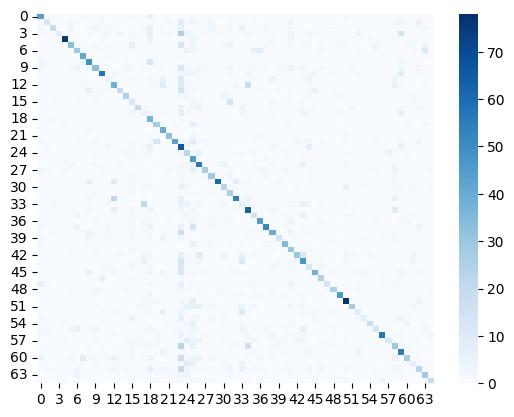

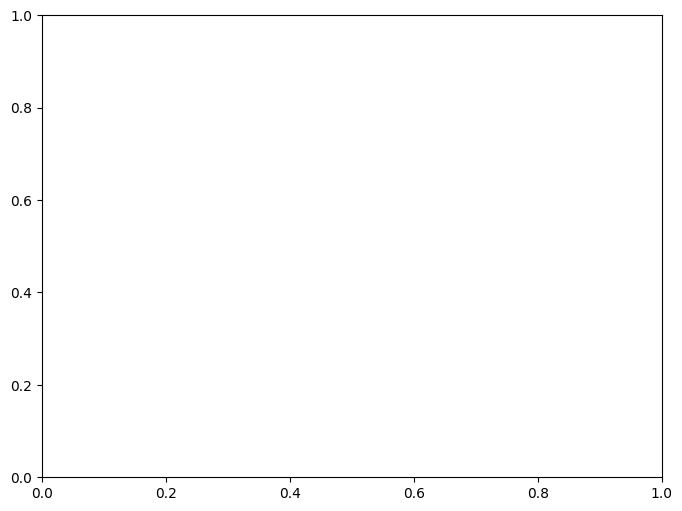

In [42]:
config = {'epochs':10, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-5}
analysis(source=["Art", "Real World", "Product"], target=["Clipart"], config=config, cache_source=cache_source, cache_target=cache_target, )

In [40]:
len(cache_target)

4365